# Importo librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit
import pandas as pd

# Cargado de archivos

In [17]:
c = 3e8 #m/s
X, Y, V, nu = [], [], [], [] # --> Cada elemento de la lista corresponde a los datos de una longitud de onda

folder = 'Mediciones/Barrido voltaje dia 3'
fname = os.listdir(folder + '/')
files = fname[:9] + fname[-5:]
for file in files:
    root = folder + '/' + file
    if file[:7] == 'barrido':
        medXYV = np.genfromtxt(root, delimiter = ',')
        N = len(medXYV)
        Xi, Yi, Vi = np.zeros(N - 1), np.zeros(N - 1), np.zeros(N - 1)
        for i, row in enumerate(medXYV[1:]):
            Xi[i], Yi[i], Vi[i] = row[0], row[1], row[2]
        X.append(Xi), Y.append(Yi), V.append(Vi)
        lamb = float(file[-9:-6])*1e-9 #m
        nu.append(2 * np.pi * c / lamb)

R = [np.sqrt(x**2 + y**2) for x, y in zip(X, Y)]

# Cálculo de $I$ y $V_0$

In [95]:
a = np.array([0, 1, 2, 3])
b = np.array([1, 4, 5, 6])
comunes = list(set(a) & set(b))
comunes

[1]

In [ ]:
#G = 10e6
G = 1
#ep = -.05e-10
ep = -.1e-10
I = [np.sqrt( (x/G)**2 + (y/G)**2 ) for x, y in zip(X, Y)]

# Obtengo el V / I = 0
def V0min(x, v, epsilon = ep, p = -1):
    xc = x[(x <= 0) & (x >= epsilon)]
    vc = v[(x <= 0) & (x >= epsilon)]
    
    xc0, vc0, ind_vc0 = xc[p], vc[p], list(vc).index(vc[p])
    err_vc0 = np.mean([vc0 - v[ind_vc0 - 1], v[ind_vc0 + 1] - vc0])

    return xc0, vc0, err_vc0

def rectas(I, V):
    #--------Recorto datos para ajuste---------
    I_corte0, V_corte0 = I[2:30], V[2:30]
    I_corte1, V_corte1 = I[(V >= 0) & (V <= .5)], V[(V >= 0) & (V <= .5)]

    #--------Ajuste---------
    lin = lambda x, a, b: a*x + b
    popt0, pcov0 = curve_fit(lin, V_corte0, I_corte0)
    popt1, pcov1 = curve_fit(lin, V_corte1, I_corte1)

    #--------Buscamos interseccion---------
    V_c0 = np.linspace(V_corte0[0], V_corte0[-1], 10_000)
    V_c1 = np.linspace(V_corte1[0], V_corte1[-1], 10_000)

    comun = set(lin(V_c0, *popt0)[:-450]) & set(lin(V_c1, *popt1)[450:])
    print(comun)

    return popt0, popt1
    



# Gráficos de las mediciones

[]


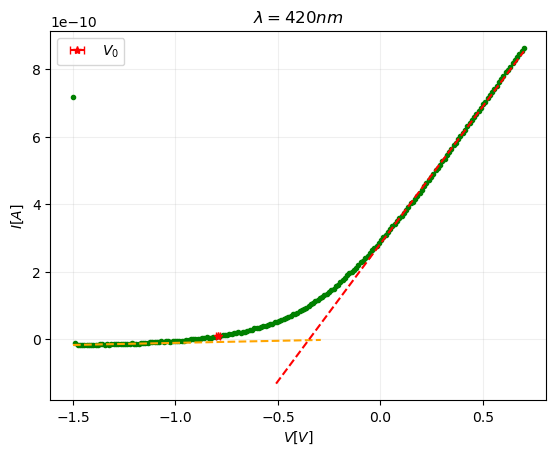

[]


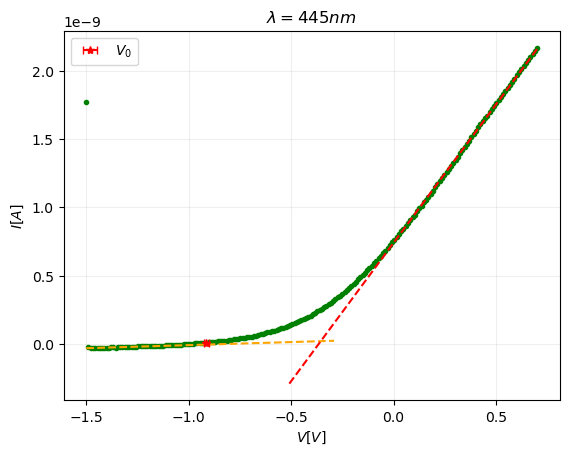

[]


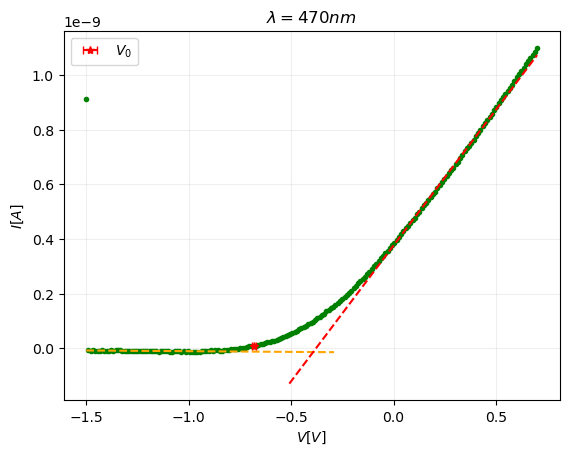

[]


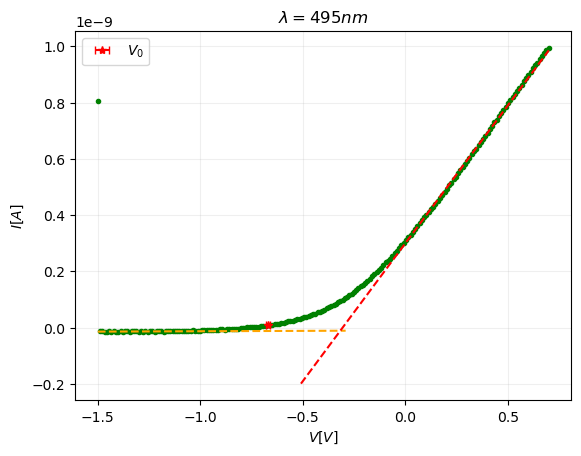

[]


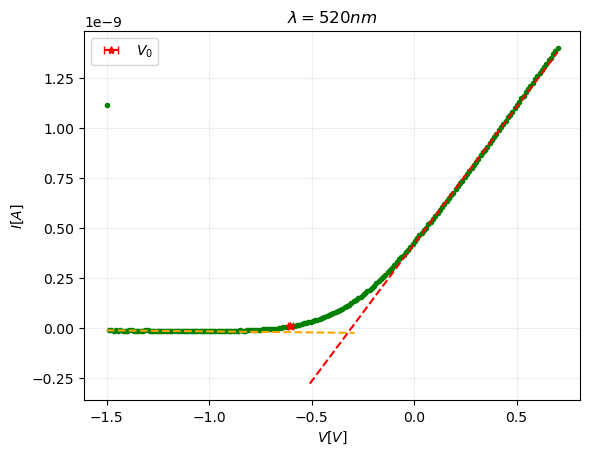

[]


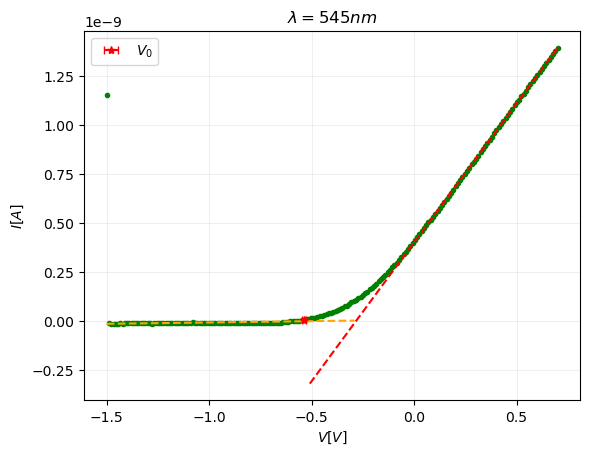

[]


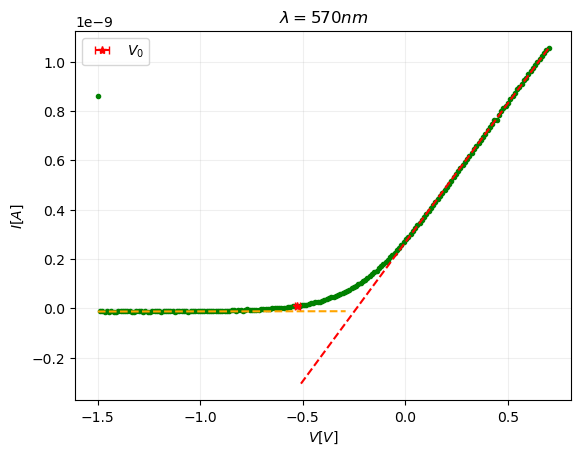

[]


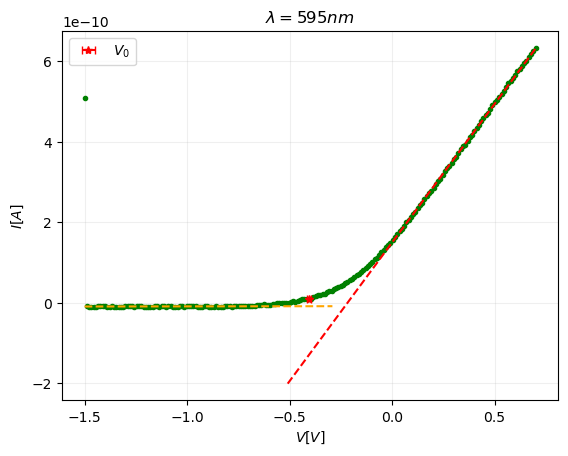

[]


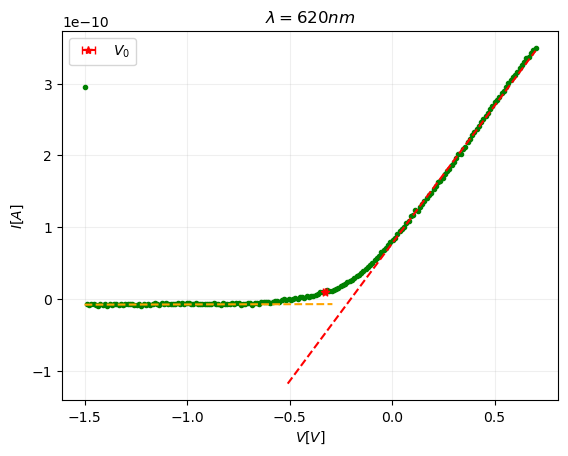

[]


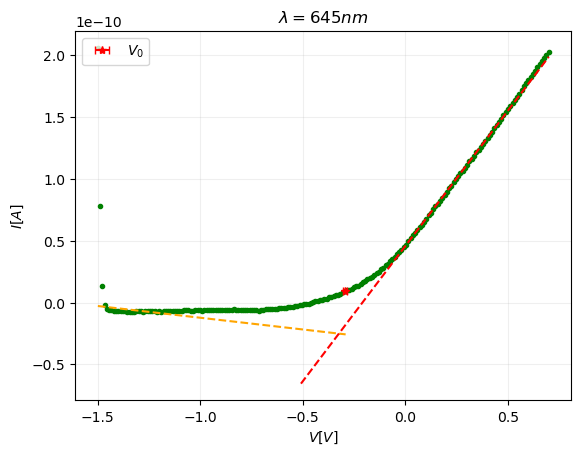

[]


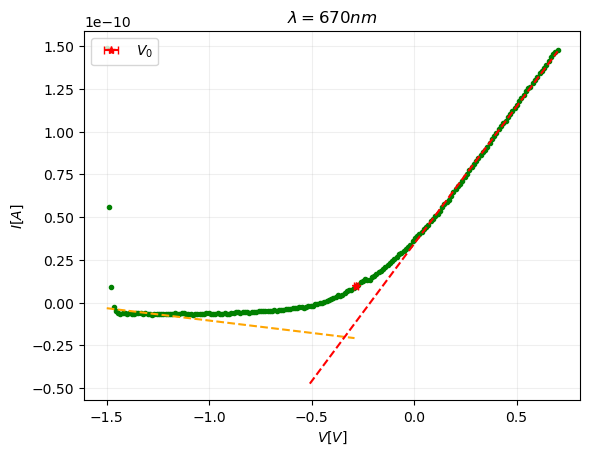

[]


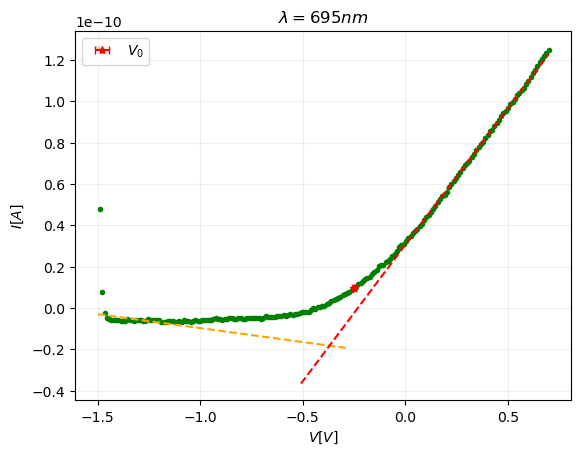

[]


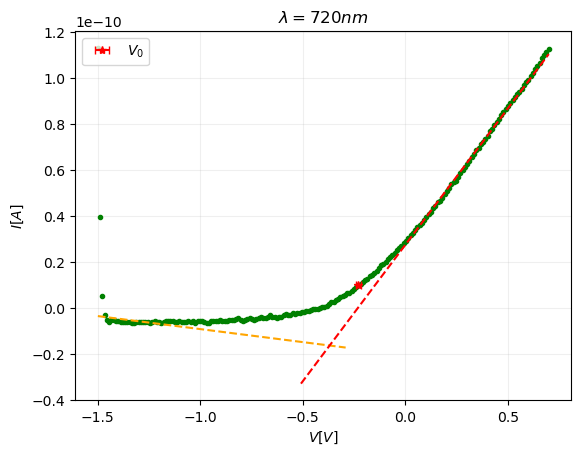

[]


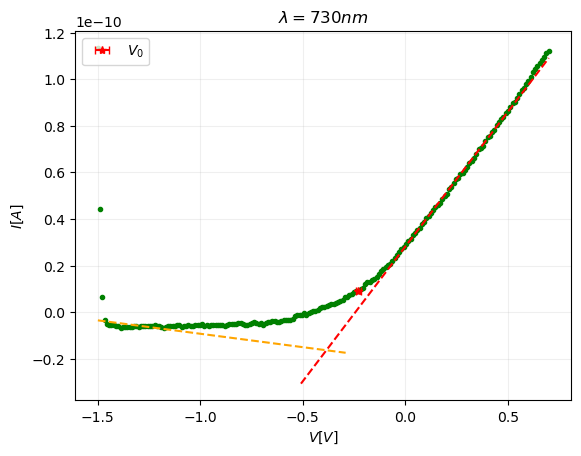

In [105]:
V0, err_V0 = np.zeros(len(X)), np.zeros(len(X))
for k in range(len(X)):
    Xc0k, V0[k], err_V0[k] = V0min(X[k], V[k])
    p0, p1 = rectas(-X[k], V[k])
    f = lambda x, a, b: a * x + b
    v_sim = np.linspace(V[k][0], V[k][-1], 1000)

    plt.figure()
    
    plt.plot(V[k], -X[k], '.', color = 'green'), plt.plot()
    #plt.plot(V_c0, -X[k], '-', color = 'blue'), plt.plot(V_c1, -X[k], '-', color = 'blue')
    plt.plot(v_sim[:-450], f(v_sim, *p0)[:-450], '--', color = 'orange')
    plt.plot(v_sim[450:], f(v_sim, *p1)[450:], '--', color = 'red')

    plt.errorbar(V0[k], -Xc0k, fmt = '*', xerr = err_V0[k], capsize = 3, 
                 linestyle = 'None', color = 'red', label = r'$V_0$') #-->Puntos de corriente nula
    
    #plt.axhline(-ep, color = 'red', linestyle = '--', 
                #alpha = 0.3, label = r'$\epsilon$') #--> Referencia tomada
    
    plt.xlabel(r'$V \left[V\right]$'), plt.ylabel(r'$I \left[A\right]$'), plt.title(rf'$\lambda = {int(1e9*c*2*np.pi/nu[k])} nm$')
    
    plt.grid(alpha = 0.2)
    plt.legend(loc = 'upper left')
    plt.show()

# Gráficos de ajuste

Función de ajuste:
$eV_0 = h \nu - \hat{\phi}$

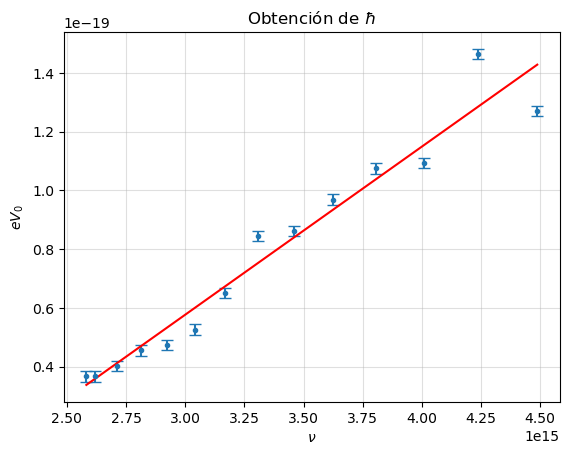

5.726082741055866e-35 3.7603405461881244e-36


In [50]:
# Defino e y paso a arrayos
elect = -1.60217663e-19 #C
V0, err_V0 = np.array(V0), np.array(err_V0)

# ------------Ajuste lineal------------
f = lambda x, a, c: a * x + c
popt, pcov = curve_fit(f, nu, elect*V0, sigma = elect*err_V0)
pcov = np.sqrt(np.diag(pcov))
h, err_h = popt[0], pcov[0]

# -----------Gráfico de ajustes----------
plt.figure()
plt.errorbar(nu, elect*V0, fmt = '.', yerr = -elect*err_V0, capsize = 4)
plt.plot(nu, f(np.array(nu), *popt), color = 'red')

plt.title(r'Obtención de $\hbar$')
plt.ylabel(r'$eV_0$')
plt.xlabel(r'$\nu$')

plt.grid(alpha = 0.4)
plt.show()

print(h, err_h)

# Barrido de longitudes de onda (dia 2)

## Cargamos los datos

In [16]:
X_nu, err_X_nu, long = [], [], []

direc = 'Mediciones/Barrido de longitudes/'
files = os.listdir(direc)
for file in files:
    root = direc + file
    df = pd.read_csv(root)
    
    X_nui, err_X_nui = -np.mean(df['X']), np.std(df['X']) #A
    X_nu.append(X_nui), err_X_nu.append(err_X_nui)
    
    long_i = float(file[-9: -6]) * 1-9 #m
    long.append(long_i)

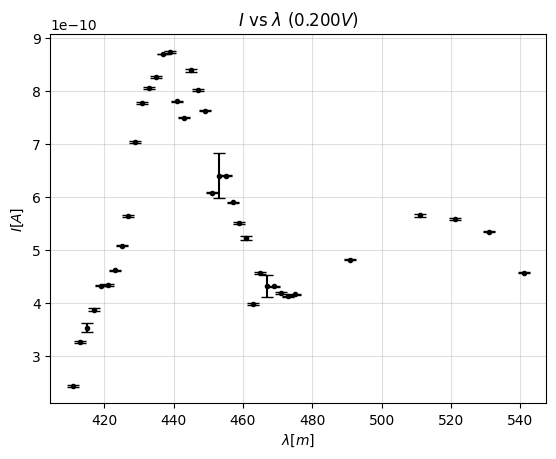

In [17]:
plt.figure()

plt.errorbar(long, X_nu, yerr = err_X_nu,
             fmt = '.', capsize = 4, color = 'black')

plt.title(r'$I$ vs $\lambda$ $(0.200V)$'), plt.ylabel(r'$I[A]$'), plt.xlabel(r'$\lambda[m]$')
plt.grid(alpha = 0.4)
plt.show()

## Barrido de longitudes (dia 3)

### Cargamos los datos

In [29]:
direc = 'Mediciones/Barrido de longitudes/medicion_completa.csv'
df = pd.read_csv(direc)
I_5v, nu_odna = -df['X'], 2*np.pi*c / df['long']

### Gráfico

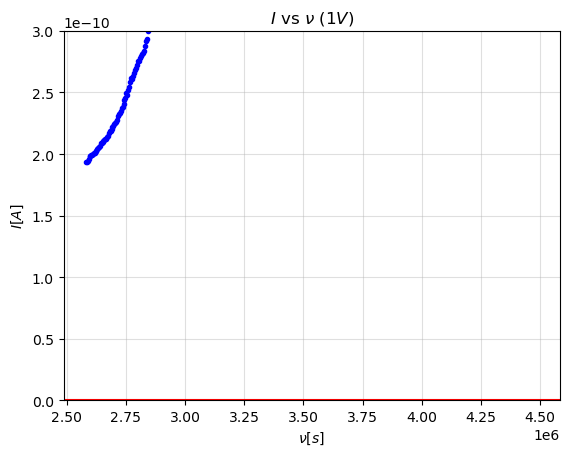

In [42]:
plt.figure()

plt.plot(nu_odna, I_5v, '.', color = 'blue'), plt.axhline(0, color = 'red')

plt.ylim(0, .3e-9)

plt.title(r'$I$ vs $\nu$ $(1V)$'), plt.ylabel(r'$I[A]$'), plt.xlabel(r'$\nu[s]$')
plt.grid(alpha = 0.4)
plt.show()